Goal:

To explore relationships between crime in Chicago and behavioral data within the PK-12 school system in Chicago with the specific focus of seeing whether not a a reliable machine learning model can be created to predict the number of reported misconducts within Chicago schools when fed police district, reported incident, and student demographic/behavioral information.

Previous ETL:

1. dl_2022 data was read in with the following constraint: 'Time Period1' == 'EOY'

2. The following columns were kept from the resulting dataframe: 'Category','School Year','# of Misconducts2','# of Group 1-2 (minor) Misconducts3','# of Group 3-4 (moderate) Misconducts4','# of Group 5-6 (major) Misconducts5', '# of Police Notifications', '% of Misconducts Resulting in Police Notification'

3. Only the following values of 'Category' were kept: 'Grade PK-2', 'Grade 3-5', 'Grade 6-8', 'Grade 9-12'

4. sl_2022 data was read in with the following constraint: 'Time Period' == 'EOY'

5. The following columns were kept from sl_2022: 'School ID', 'School Name','School Network','School Year','# of Misconducts','# of Group 1-2 Misconducts','# of Group 3-4 Misconducts', '# of Group 5-6 Misconducts', '# of Suspensions (includes ISS and OSS)','# of Police Notifications', '% of Misconducts Resulting in a Police Notification'

6. cps_safety.csv was read in and merged with the transformed sl_2022 data:  how='inner', left_on ='School_ID', right_on ='School ID'

7. The following columns were dropped from the merged df:  'Unnamed: 0', 'School ID', 'Long_Name'

8. A new df (named x1) was created from the merged df with the following columns: 'Community Area Number', 'Ward', 'Police District', 'Primary_Category',
    'Zip', 'Student_Count_Total', 'Student_Count_Low_Income', 'Student_Count_Special_Ed',
    'Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White',
    'Student_Count_Asian', 'Student_Count_Native_American', 'Student_Count_Asian_Pacific_Islander',
    'Student_Count_Hawaiian_Pacific_Islander', 'Overall_Rating', 'School_Survey_Safety',
    '# of Misconducts', '# of Group 1-2 Misconducts', '# of Group 3-4 Misconducts',
    '# of Group 5-6 Misconducts', '# of Suspensions (includes ISS and OSS)', '# of Police Notifications',
    '% of Misconducts Resulting in a Police Notification'

9. Crime data (cc2) with year == 2022 was pulled in from a sql database, and the following columns were kept: 'community_area', 'primary_type', 'domestic'

10. 'community_area' was converted to int type.

11. A new dataframe (x2) was created by merging x1 and cc2 using an inner join with left_on = 'Community Area Number' and right_on = 'community_area'

12. x2 was exported as hdf.

In [7]:
# Importing the needed packages and libraries before preparing the data and implementing a model.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn.metrics as metrics
import xgboost as xgb
import shap

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import plot_importance

In [8]:
x2 = pd.read_hdf(r"x2.h5")

In [9]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093883 entries, 0 to 15093882
Data columns (total 27 columns):
 #   Column                                               Dtype 
---  ------                                               ----- 
 0   Community Area Number                                int64 
 1   Ward                                                 int64 
 2   Police District                                      int64 
 3   Primary_Category                                     object
 4   Zip                                                  int64 
 5   Student_Count_Total                                  int64 
 6   Student_Count_Low_Income                             int64 
 7   Student_Count_Special_Ed                             int64 
 8   Student_Count_Black                                  int64 
 9   Student_Count_Hispanic                               int64 
 10  Student_Count_White                                  int64 
 11  Student_Count_Asian                

In [5]:
x2.shape

(15093883, 27)

In [10]:
x3 = x2.drop(columns=['# of Group 1-2 Misconducts', '# of Group 3-4 Misconducts', '# of Group 5-6 Misconducts', '# of Misconducts', 'Overall_Rating', 'primary_type',
    'Community Area Number', 'Ward', 'community_area', 'domestic', 'Zip', 'Student_Count_Total', 'School_Survey_Safety', '% of Misconducts Resulting in a Police Notification'])
x3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093883 entries, 0 to 15093882
Data columns (total 13 columns):
 #   Column                                   Dtype 
---  ------                                   ----- 
 0   Police District                          int64 
 1   Primary_Category                         object
 2   Student_Count_Low_Income                 int64 
 3   Student_Count_Special_Ed                 int64 
 4   Student_Count_Black                      int64 
 5   Student_Count_Hispanic                   int64 
 6   Student_Count_White                      int64 
 7   Student_Count_Asian                      int64 
 8   Student_Count_Native_American            int64 
 9   Student_Count_Asian_Pacific_Islander     int64 
 10  Student_Count_Hawaiian_Pacific_Islander  int64 
 11  # of Suspensions (includes ISS and OSS)  object
 12  # of Police Notifications                object
dtypes: int64(10), object(3)
memory usage: 1.6+ GB


In [11]:
x4 = x2['# of Misconducts']
x4.info()

<class 'pandas.core.series.Series'>
Int64Index: 15093883 entries, 0 to 15093882
Series name: # of Misconducts
Non-Null Count     Dtype 
--------------     ----- 
15093883 non-null  object
dtypes: object(1)
memory usage: 230.3+ MB


In [12]:
x4 = x4.astype(int)
x4.info()

<class 'pandas.core.series.Series'>
Int64Index: 15093883 entries, 0 to 15093882
Series name: # of Misconducts
Non-Null Count     Dtype
--------------     -----
15093883 non-null  int32
dtypes: int32(1)
memory usage: 172.7 MB


In [9]:
print(x3.shape)
print(x4.shape)

(15093883, 13)
(15093883,)


In [13]:
# Creating dummy variables for categorical data.

dummies = pd.get_dummies(x3['Police District']).rename(columns=lambda x: 'Police District_' + str(x))
dummies.head()

,Police District_1,Police District_2,Police District_3,Police District_4,Police District_5,Police District_6,Police District_7,Police District_8,Police District_9,Police District_10,...,Police District_14,Police District_15,Police District_16,Police District_17,Police District_18,Police District_19,Police District_20,Police District_22,Police District_24,Police District_25
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dummies2 = pd.get_dummies(x3['Primary_Category']).rename(columns=lambda x: 'Primary_Category_' + str(x))
dummies2.head()

,Primary_Category_ES,Primary_Category_HS,Primary_Category_MS
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [15]:
x3d = pd.concat([x3, dummies, dummies2], axis=1)
x3d.head()

,Police District,Primary_Category,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Asian_Pacific_Islander,...,Police District_17,Police District_18,Police District_19,Police District_20,Police District_22,Police District_24,Police District_25,Primary_Category_ES,Primary_Category_HS,Primary_Category_MS
0,10,ES,196,40,30,198,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,10,ES,196,40,30,198,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10,ES,196,40,30,198,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,10,ES,196,40,30,198,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,10,ES,196,40,30,198,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
x3d = x3d.drop(columns=['Police District', 'Primary_Category'])
x3d.head()

,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Asian_Pacific_Islander,Student_Count_Hawaiian_Pacific_Islander,# of Suspensions (includes ISS and OSS),...,Police District_17,Police District_18,Police District_19,Police District_20,Police District_22,Police District_24,Police District_25,Primary_Category_ES,Primary_Category_HS,Primary_Category_MS
0,196,40,30,198,2,0,0,0,0,20,...,0,0,0,0,0,0,0,1,0,0
1,196,40,30,198,2,0,0,0,0,20,...,0,0,0,0,0,0,0,1,0,0
2,196,40,30,198,2,0,0,0,0,20,...,0,0,0,0,0,0,0,1,0,0
3,196,40,30,198,2,0,0,0,0,20,...,0,0,0,0,0,0,0,1,0,0
4,196,40,30,198,2,0,0,0,0,20,...,0,0,0,0,0,0,0,1,0,0


In [18]:
# Making sure everything is properly typed.

for column in x3d.columns:
    if x3d[column].dtype == 'object':
        x3d[column] = x3d[column].astype(np.int64)

print(x3d.info())
print(x3d.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15093883 entries, 0 to 15093882
Data columns (total 37 columns):
 #   Column                                   Dtype
---  ------                                   -----
 0   Student_Count_Low_Income                 int64
 1   Student_Count_Special_Ed                 int64
 2   Student_Count_Black                      int64
 3   Student_Count_Hispanic                   int64
 4   Student_Count_White                      int64
 5   Student_Count_Asian                      int64
 6   Student_Count_Native_American            int64
 7   Student_Count_Asian_Pacific_Islander     int64
 8   Student_Count_Hawaiian_Pacific_Islander  int64
 9   # of Suspensions (includes ISS and OSS)  int64
 10  # of Police Notifications                int64
 11  Police District_1                        uint8
 12  Police District_2                        uint8
 13  Police District_3                        uint8
 14  Police District_4                        uint8
 

In [19]:
# Creating a smaller dataframe for testing using every 1000th row of the larger df.

x3d_1000 = x3d.iloc[::1000]
x4_1000 = x4.iloc[::1000]

print(x3d_1000.shape)
print(x4_1000.shape)

(15094, 37)
(15094,)


In [20]:
# X = np.asarray(x3d_1000)
y = np.asarray(x4_1000)

X = (x3d_1000)
# y = (x4_1000)

print(X.shape)
print(y.shape)

(15094, 37)
(15094,)


In [21]:
# Splitting up the data before throwing into a linear regression model.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [203]:
# Using a basic LR as only one predictor variable is being used.

regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

print('Training accuracy {:.3f}'.format(regr.score(X_train, y_train)))
print('Testing accuracy {:.3f}'.format(regr.score(X_test, y_test)))

cv_scores = cross_val_score(regr, X_train, y_train, cv = 4)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Training accuracy 0.472
Testing accuracy 0.453
Mean cross-val score: 0.49
MSE:  168093.31
RMSE: 409.99


In [146]:
regr.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [204]:
# n_jobs default: None

params = {'n_jobs': [1,3,5,7,9],
}
 
regr_tuned = GridSearchCV(estimator=regr,
    param_grid=params,
    cv=4,
    n_jobs=-1,
    verbose=3)
regr_tuned.fit(X_train, y_train)
print(regr_tuned.best_score_)
print(regr_tuned.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
0.4879301148709911
{'n_jobs': 1}


In [21]:
regr = LinearRegression(n_jobs=1)
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

print('Training accuracy {:.3f}'.format(regr.score(X_train, y_train)))
print('Testing accuracy {:.3f}'.format(regr.score(X_test, y_test)))

cv_scores = cross_val_score(regr, X_train, y_train, cv = 4)
print("Mean cross-val score: %.2f" % cv_scores.mean())

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Training accuracy 0.472
Testing accuracy 0.453
Mean cross-val score: 0.49
MSE:  168093.31
RMSE: 409.99


The initial LR provided suboptimal scores, and the LR model is a bit lacking in available tunable parameters with the tuned model making no difference.

The data will be scaled before a few other algorithms are tested.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

sc = StandardScaler()

# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.transform(X_test)

sc.fit(X_train)
sc.transform(X_test)

X_train_sc = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [22]:
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 42)
xgbt = xgb.XGBRegressor(random_state = 42, verbosity=0)
dtree = DecisionTreeRegressor(random_state = 42)

algo = [xgbt,rf, ridge,lasso,knn,dtree]
result = []

for i in algo:
        model = i.fit(X_train_sc,y_train),
        print('Algorithm:  ' + str(i)),
        print('Training accuracy {:.3f}'.format(i.score(X_train_sc, y_train))),
        print('Testing accuracy {:.3f}'.format(i.score(X_test_sc, y_test))),

Algorithm:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
Training accuracy 0.997
Testing accuracy 0.969
Algorithm:  RandomForestRegressor(random_state=42)
Training accuracy 0.988
Testing accuracy 0.954
Algorithm:  Ridge(random_state=42)
Training accuracy 0.472
Testing accuracy 0.453
Algorithm:  Lasso(rand

Pivoting over to XGBRegressor.

In [23]:
xg = xgb.XGBRegressor()

xg.fit(X_train_sc, y_train)

predicted = xg.predict(X_test_sc)
cv_scores = cross_val_score(xg, X_train_sc, y_train, cv = 5)
y_pred = xg.predict(X_test_sc)
mse = mean_squared_error(y_test, y_pred)

print('Training accuracy {:.3f}'.format(xg.score(X_train_sc, y_train)))
print('Testing accuracy {:.3f}'.format(xg.score(X_test_sc, y_test)))
print("Mean cross-val score: %.2f" % cv_scores.mean())
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Training accuracy 0.997
Testing accuracy 0.969
Mean cross-val score: 0.88
MSE:  9415.05
RMSE: 97.03


In [150]:
xg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
params = {'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1 , 2, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.2, 0.05],
    'subsample': [0.1, 0.3, 0.5, 0.8, 0.05],
    'colsample_bytree': [0.2, 0.45, 0.75, 0.9]
}
 
xg_tuned = GridSearchCV(estimator=xg,
    param_grid=params,
    cv=4,
    n_jobs=-1,
    verbose=3)
xg_tuned.fit(X_train_sc, y_train)
print(xg_tuned.best_score_)
print(xg_tuned.best_params_)

In [24]:
xg = xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.05, max_depth=9, min_child_weight=1, subsample=0.5)

xg.fit(X_train_sc, y_train)

predicted = xg.predict(X_test_sc)
cv_scores = cross_val_score(xg, X_train_sc, y_train, cv = 5)
y_pred = xg.predict(X_test_sc)
mse = mean_squared_error(y_test, y_pred)

print('Training accuracy {:.3f}'.format(xg.score(X_train_sc, y_train)))
print('Testing accuracy {:.3f}'.format(xg.score(X_test_sc, y_test)))
print("Mean cross-val score: %.2f" % cv_scores.mean())
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

Training accuracy 0.997
Testing accuracy 0.978
Mean cross-val score: 0.89
MSE:  6776.98
RMSE: 82.32


In [27]:
# The scale makes it a bit difficult to extrapolate exact meaning, but this visual is still good for those who would like to see the the forest for the trees.
 
# X_train, X_test, y_train, y_test = train_test_split(x3d_1000, x4_1000, test_size = 0.25, random_state=42)

# train_pp = X_train.copy()
# train_pp.insert(0, '# of Misconducts', y_train)
# _ = sns.pairplot(train_pp, kind='reg', diag_kind='kde')

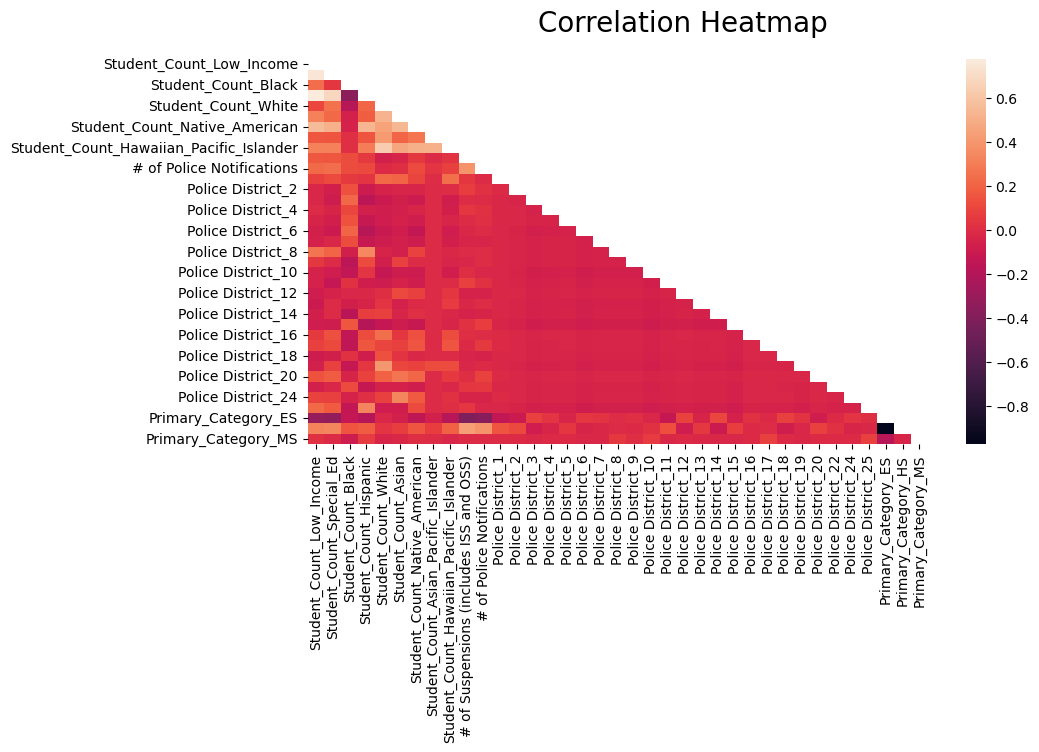

In [200]:
mtr = x3d_1000.corr()
mask = np.zeros_like(mtr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,5))
plt.suptitle("Correlation Heatmap", size=20)
sns.heatmap(mtr, mask= mask, annot=False, annot_kws={"size": 10});

In [164]:
# plot_importance(xg, max_num_features = 20)
# plt.show()

In [25]:
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test_sc)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


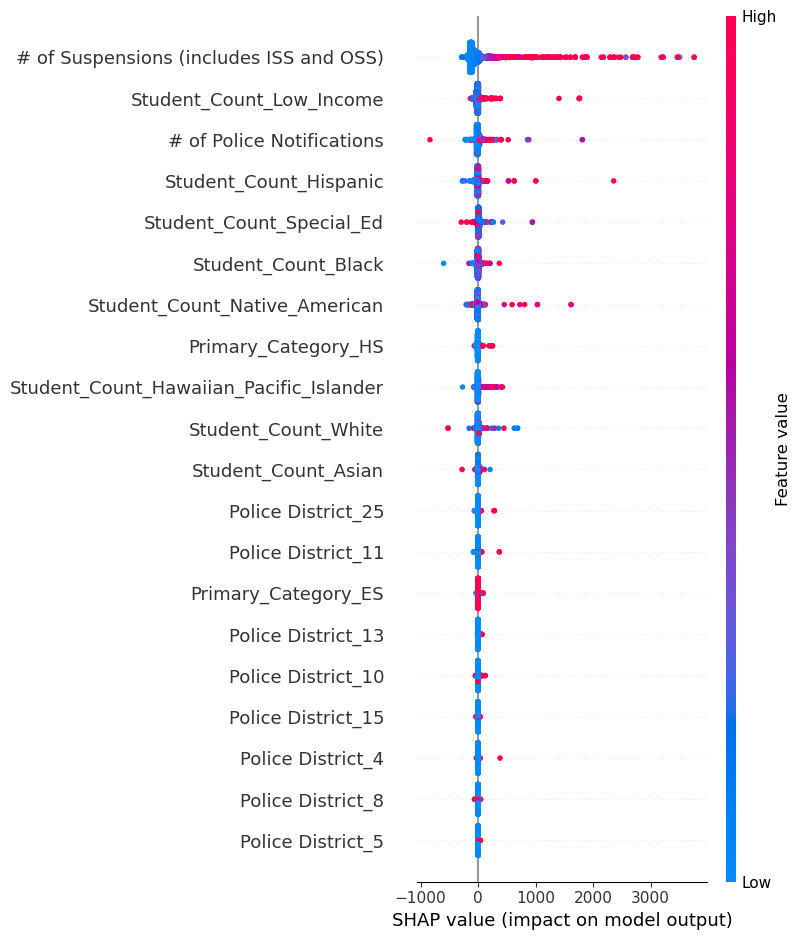

In [26]:
# viz

shap.summary_plot(shap_values, X_test_sc)

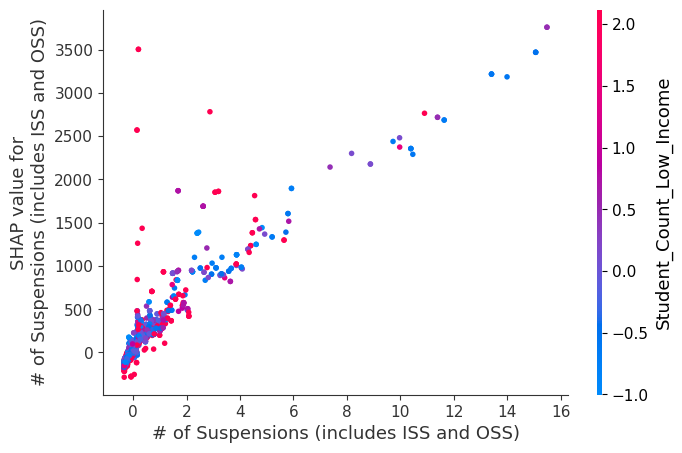

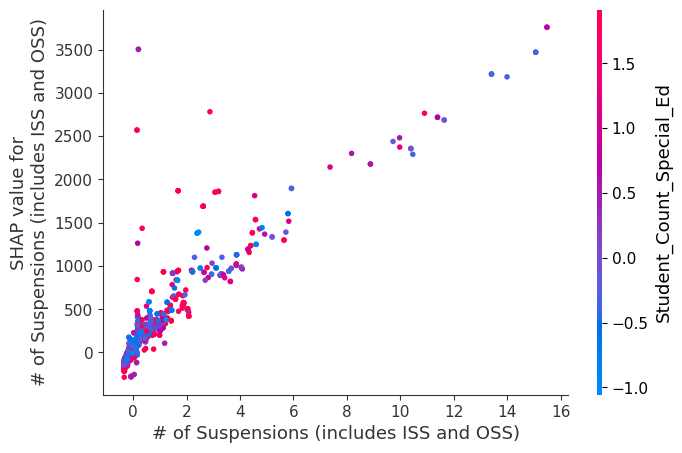

In [28]:
# viz

shap.dependence_plot('# of Suspensions (includes ISS and OSS)', shap_values, X_test_sc, interaction_index='Student_Count_Low_Income')
shap.dependence_plot('# of Suspensions (includes ISS and OSS)', shap_values, X_test_sc, interaction_index='Student_Count_Special_Ed')

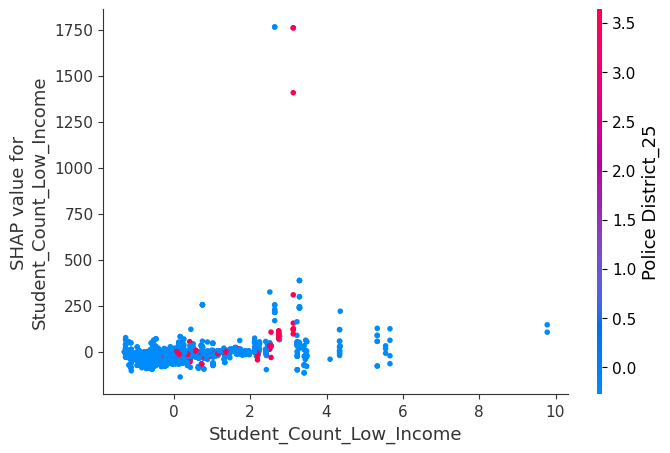

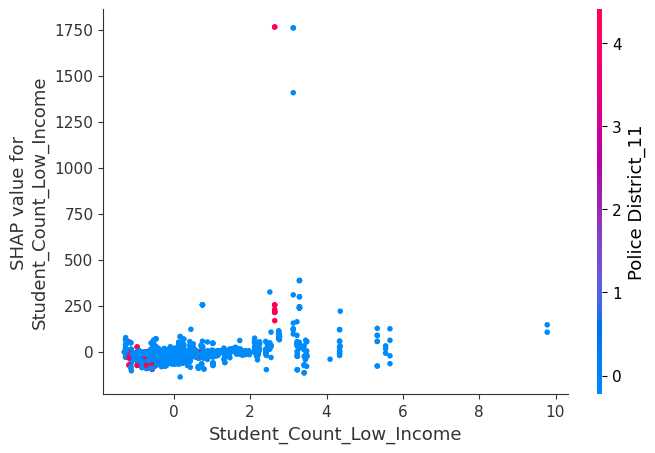

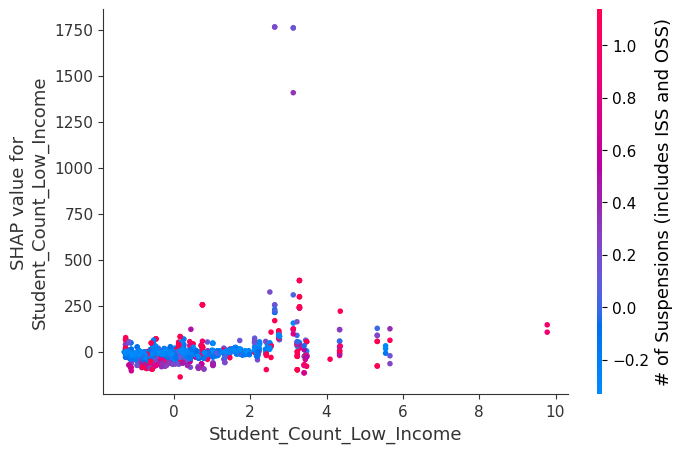

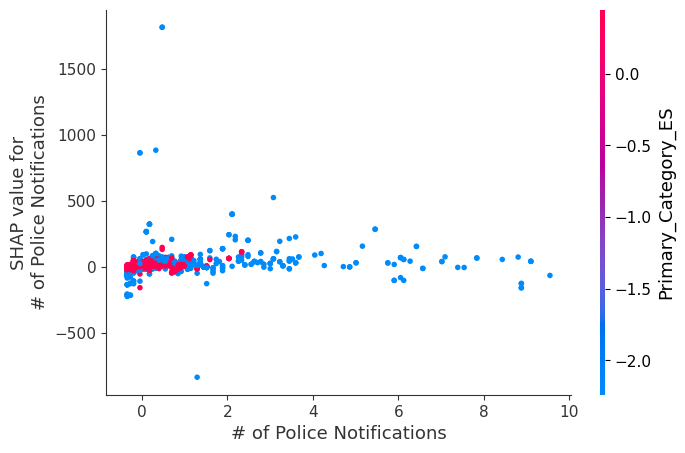

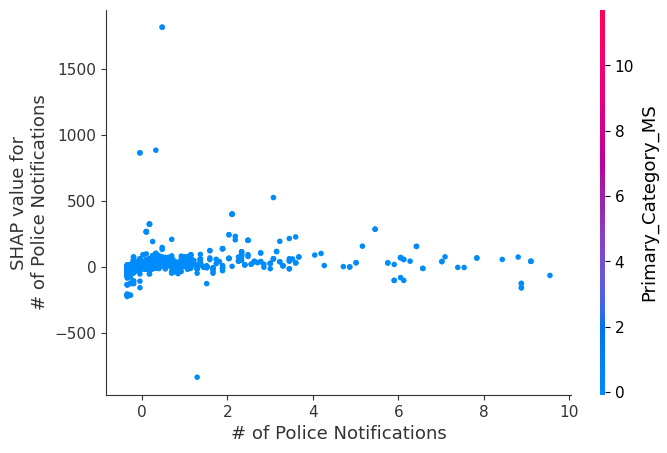

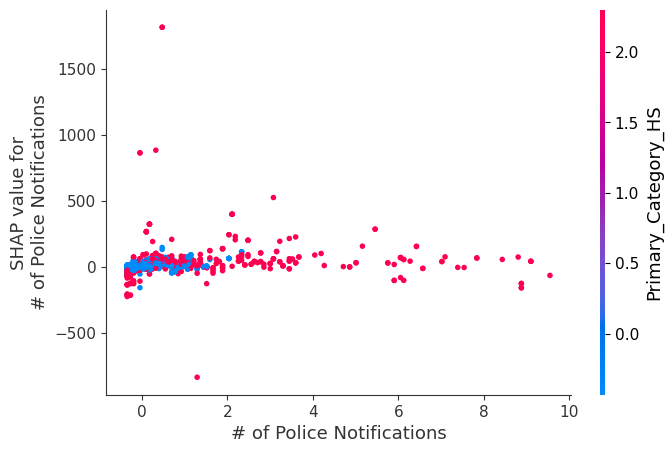

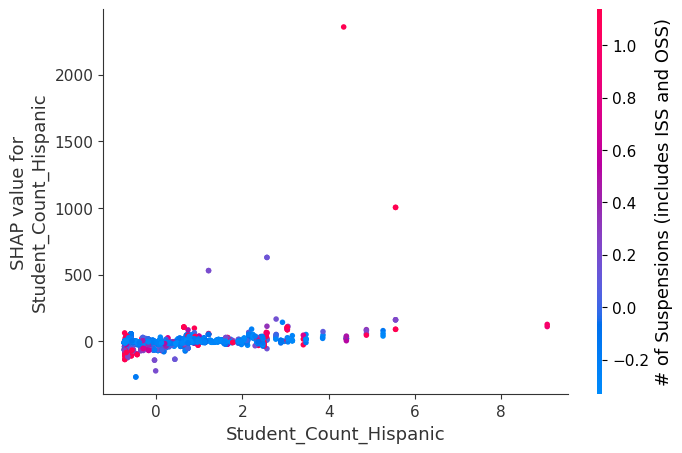

In [29]:
shap.dependence_plot('Student_Count_Low_Income', shap_values, X_test_sc, interaction_index='Police District_25')
shap.dependence_plot('Student_Count_Low_Income', shap_values, X_test_sc, interaction_index='Police District_11')
shap.dependence_plot('Student_Count_Low_Income', shap_values, X_test_sc)
shap.dependence_plot('# of Police Notifications', shap_values, X_test_sc, interaction_index='Primary_Category_ES')
shap.dependence_plot('# of Police Notifications', shap_values, X_test_sc, interaction_index='Primary_Category_MS')
shap.dependence_plot('# of Police Notifications', shap_values, X_test_sc, interaction_index='Primary_Category_HS')
shap.dependence_plot('Student_Count_Hispanic', shap_values, X_test_sc)

In [209]:
# y_pred = xg.predict(X_test_sc)

# plt.plot(y_test, color='blue', label='Actual')
# plt.plot(y_pred, color='red', label='Predicted')

# plt.legend()
# plt.show()

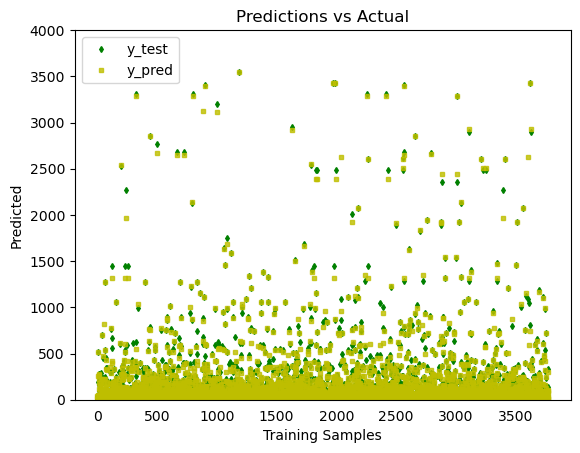

In [197]:
plt.figure()
plt.plot(y_test, 'gd', label='y_test', markersize=3)
plt.plot(y_pred, 'ys', label='y_pred', markersize=3, alpha=.8)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.ylabel('Predicted')
plt.ylim(0, 4000)
plt.xlabel('Training Samples')
plt.legend(loc='best')
plt.title('Predictions vs Actual')
plt.show()

Plotting predictor actual vs predicted values doesn't seem to provide anything usable.

The tuned model works marginally better than the base model, so will be using the tuned parameters for the complete data set.

In [ ]:
X = np.asarray(x3d)
y = np.asarray(x4)

print(X.shape)
print(y.shape)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
xg = xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.05, max_depth=9, min_child_weight=1, subsample=0.5)

xg.fit(X_train_sc, y_train)

predicted = xg.predict(X_test_sc)
cv_scores = cross_val_score(xg, X_train_sc, y_train, cv = 5)
y_pred = xg.predict(X_test_sc)
mse = mean_squared_error(y_test, y_pred)

print('Training accuracy {:.3f}'.format(xg.score(X_train_sc, y_train)))
print('Testing accuracy {:.3f}'.format(xg.score(X_test_sc, y_test)))
print("Mean cross-val score: %.2f" % cv_scores.mean())
print('MSE:  %.2f' % mse)
print('RMSE: %.2f' % mse**(0.5))

After thoughts:

Not only is a reliable machine learning model able to be created to predict the number of reported misconducts within Chicago schools when fed police district, reported incident, and student demographic/behavioral information, but the model seems to be able to predict the number of reported misconducts with an extremely high accuracy.

These results show a need for two further analysis projects:  

1. Qualitative analysis regarding the connection and biases between the number of misconducts and how they relate to low income, special ed, and racial demographics.

2. Qualitative analysis regarding the connection between the number of misconducts and how they relate specifically to the police districts (25, 11, 13, 10, 15, 4, 8, 5).

Notes:

When trying to run the tuned model on the larger data set, issues regarding available memory arose. 